In [ ]:
!pip install scikit-learn

In [ ]:
!pip install scipy

In [ ]:
!pip install seaborn

In [ ]:
!pip install matplotlib

In [ ]:
!pip install cohere

In [ ]:
!pip install ipywidgets

In [ ]:
!pip install transformers

Privacy-Aware Numerical Data Analysis System
Determining masking strategies using Local LLM...
Masking Strategy Determined: Here is the analysis and suggested masking strategies for each column:

{
    "Invoice ID": "synthetic", 
    // unique identifier, needs to maintain statistical similarity
    "Branch": "shuffling", 
    // categorical data, can be shuffled without losing meaning
    "City": "shuffling", 
    // categorical data, can be shuffled without losing meaning
    "Customer type": "shuffling", 
    // categorical data, can be shuffled without losing meaning
    "Gender": "shuffling", 
    // categorical data, can be shuffled without losing meaning
    "Product line": "shuffling", 
    // categorical data, can be shuffled without losing meaning
    "Unit price": "multiplicative", 
    // proportional relationships, multiplicative masking preserves ratios
    "Quantity": "multiplicative", 
    // proportional relationships, multiplicative masking preserves ratios
    "Tax 5

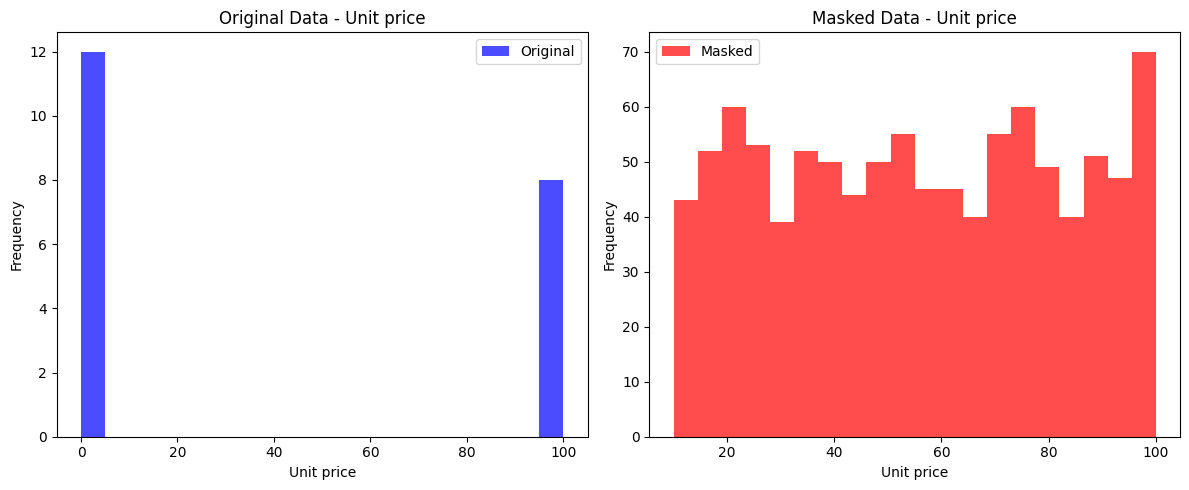

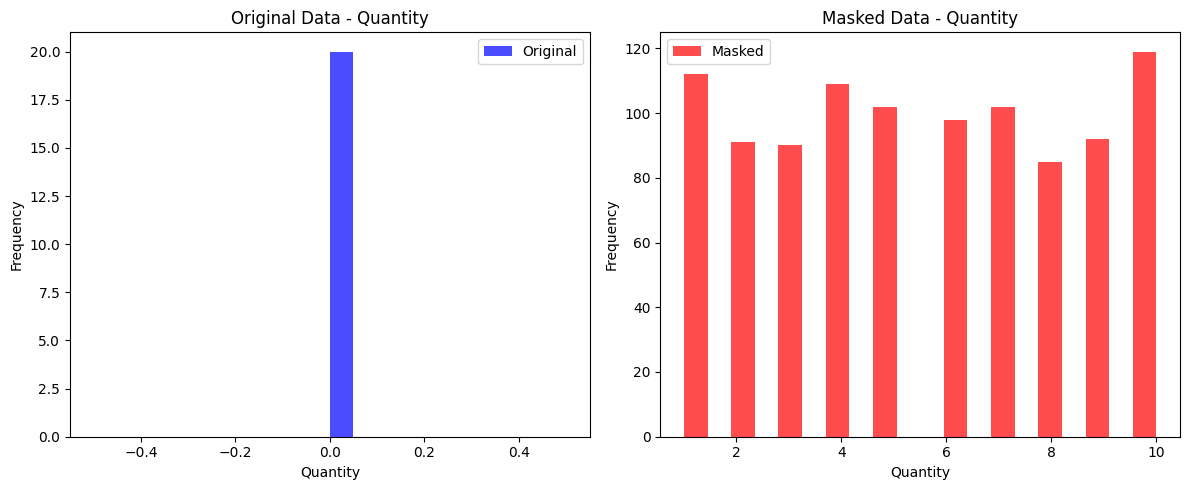

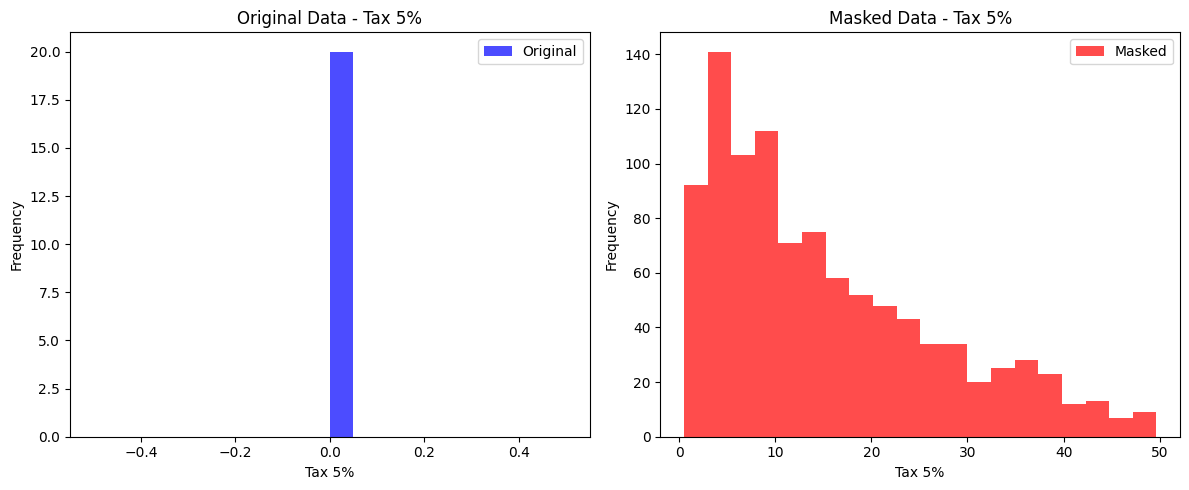

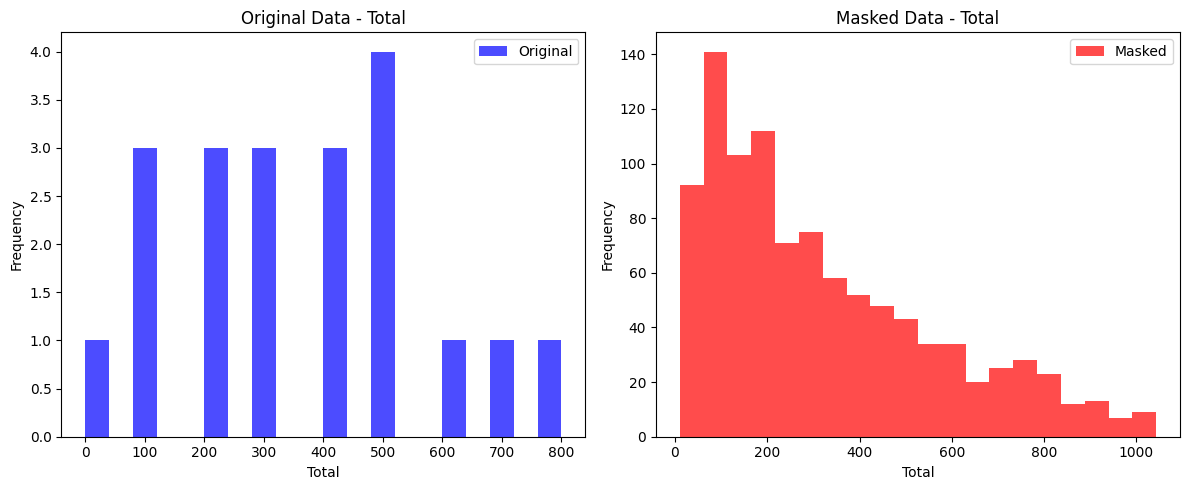

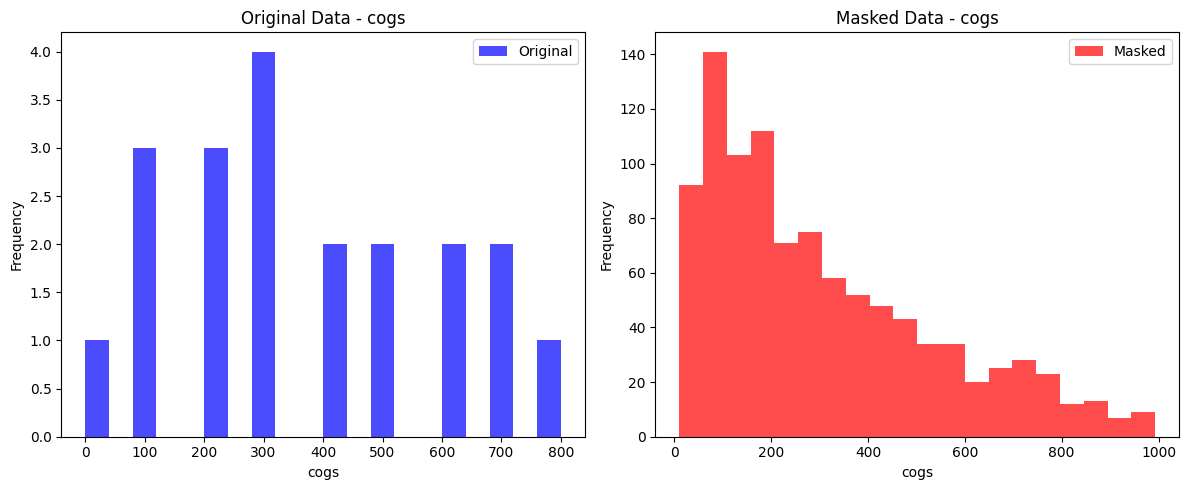

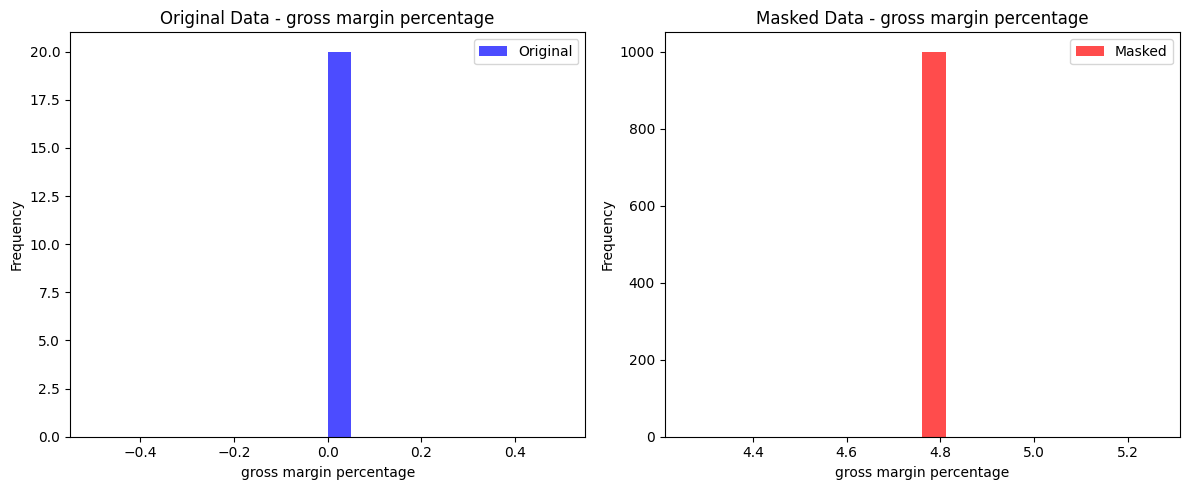

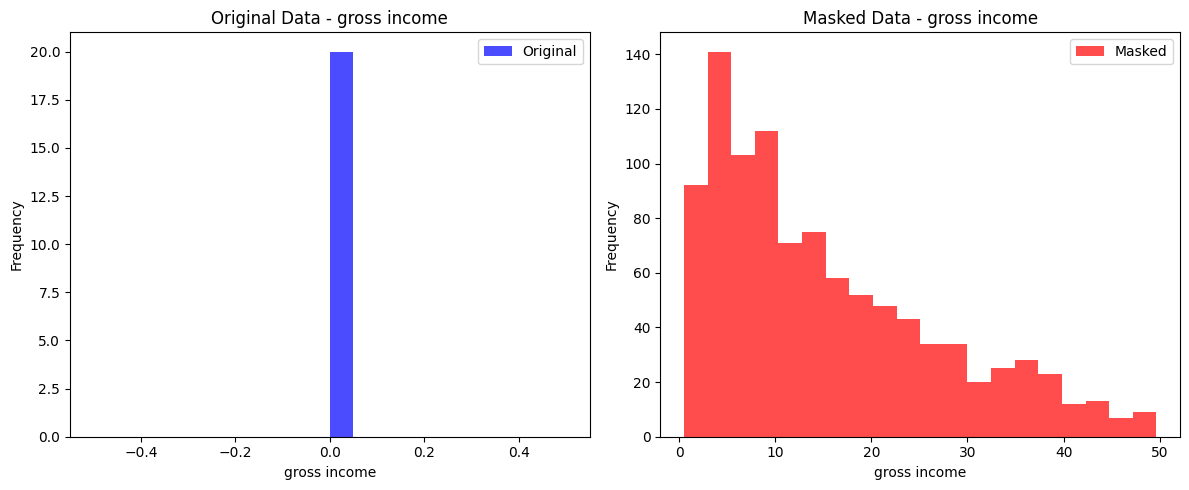

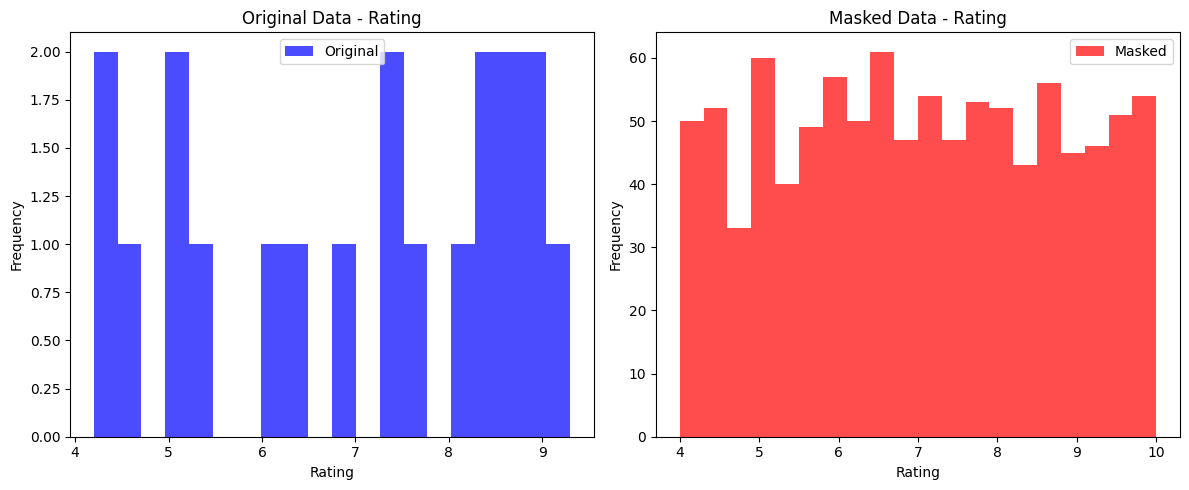

Now comparing the stats numerically:

Original Data Statistics:
        Unit price   Quantity     Tax 5%       Total        cogs  \
count   20.000000  20.000000  20.000000   20.000000   20.000000   
mean    55.086500   6.500000  17.897775  375.853275  357.955500   
std     22.191901   2.874571  10.191544  214.022417  203.830873   
min     21.870000   2.000000   2.187000   45.927000   43.740000   
25%     38.955000   3.750000   9.802875  205.860375  196.057500   
50%     52.325000   7.000000  17.615750  369.930750  352.315000   
75%     70.502500   9.000000  25.709250  539.894250  514.185000   
max     99.550000  10.000000  36.065000  757.365000  721.300000   

       gross margin percentage  gross income     Rating  
count                20.000000     20.000000  20.000000  
mean                  4.761905     17.897775   6.975000  
std                   0.000000     10.191544   1.738988  
min                   4.761905      2.187000   4.200000  
25%                   4.761905      9.802

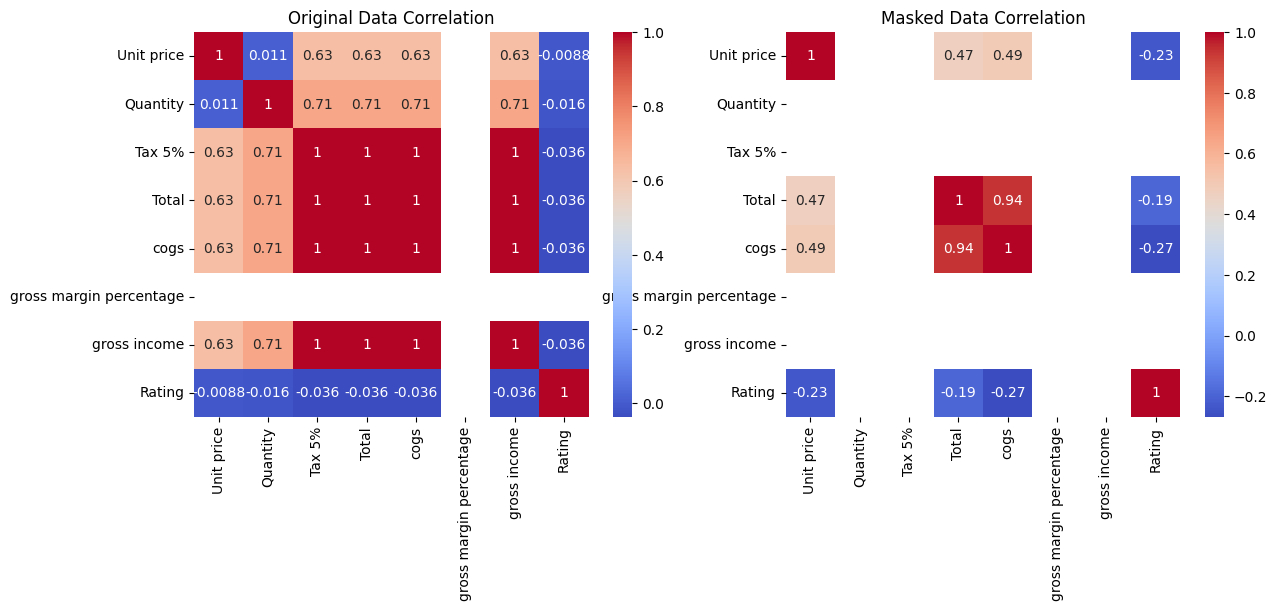

Comparing the two correlation matrices



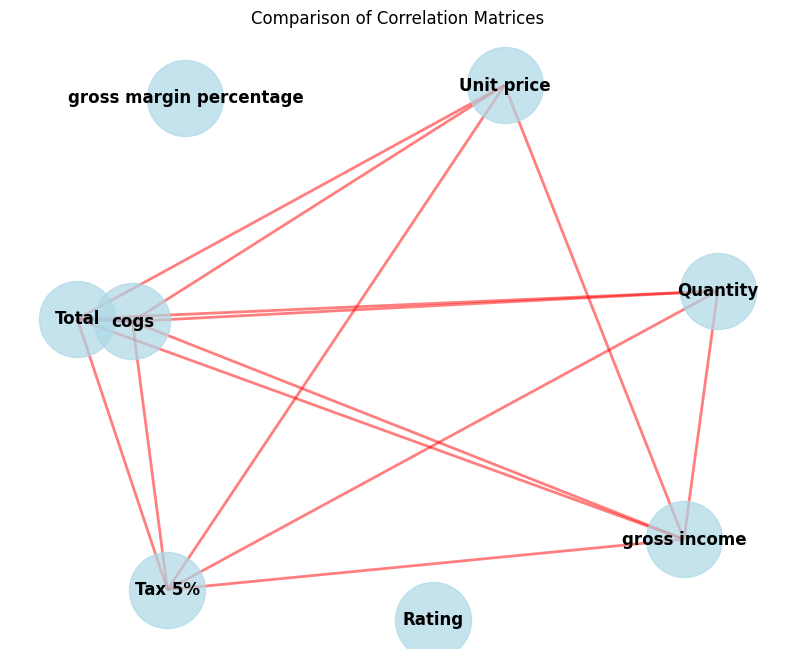


Masked Dataset:
       Invoice ID Branch      City Customer type  Gender  \
521  451-28-5717      C  Mandalay        Normal  Female   
737  137-63-5492      A    Yangon        Member    Male   
740  733-29-1227      A  Mandalay        Normal    Male   
660  322-02-2271      B    Yangon        Normal    Male   
411  569-71-4390      A    Yangon        Normal    Male   

               Product line  Unit price  Quantity  Tax 5%  Total       Date  \
521       Sports and travel       100.0       0.0     0.0  600.0  3/20/2019   
737      Home and lifestyle         0.0       0.0     0.0  500.0  1/29/2019   
740  Electronic accessories         0.0       0.0     0.0  400.0  3/23/2019   
660      Home and lifestyle         0.0       0.0     0.0  100.0   2/3/2019   
411       Health and beauty         0.0       0.0     0.0    0.0  1/25/2019   

      Time  Payment   cogs  gross margin percentage  gross income  Rating  
521  11:23     Cash  500.0                      0.0           0.0     7.3  


In [5]:
"""Now JSON parsing error is NOT occurring here.
Th output of this code is like, local LLM is suggesting masking method for each column, & giving the masked output then this output is sent to global LLM and providing some analysis based on it.

Used the Cohere platform (just for checking whether global LLM is giving output or not)."""

import pandas as pd
import random
import requests
import re
from datetime import datetime, timedelta
import cohere
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.metrics import mean_absolute_error

# Cohere API Client
co = cohere.Client('YOUR API KEY') 

def plot_histograms(original_df, masked_df):
    num_cols = original_df.select_dtypes(include=['number']).columns  # Select numerical columns

    for col in num_cols:
        plt.figure(figsize=(12, 5))

        # Histogram before masking
        plt.subplot(1, 2, 1)
        plt.hist(original_df[col].dropna(), bins=20, alpha=0.7, color='blue', label='Original')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Original Data - {col}')
        plt.legend()

        # Histogram after masking
        plt.subplot(1, 2, 2)
        plt.hist(masked_df[col].dropna(), bins=20, alpha=0.7, color='red', label='Masked')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Masked Data - {col}')
        plt.legend()

        plt.tight_layout()
        plt.show()


# Function to communicate with local LLM to decide masking strategies
def determine_masking_strategy(df):
    GROQCLOUD_API_KEY = "------"  # Replace with your API key
    GROQCLOUD_API_URL = "https://api.groq.com/openai/v1/chat/completions"
    
    headers = {"Authorization": f"Bearer {GROQCLOUD_API_KEY}", "Content-Type": "application/json"}
    
    prompt = f"""Analyze the following columns and suggest appropriate masking strategies for each in JSON format. 
The strategies include:
- Rounding: For floating-point columns where precision isn’t critical.
- Synthetic: For columns where statistical similarity is important but data must be anonymized.
- Shuffling: For columns where data points can be randomized without affecting the analysis.
- Multiplicative: For columns with proportional relationships (e.g., salary or sales).

Example response format:
{{
    "Column1": "rounding",
    "Column2": "shuffling",
    "Column3": "multiplicative",
    "Column4": "synthetic"
}}

Dataset Columns: {list(df.columns)}
"""
    
    payload = {
        "model": "llama3-70b-8192",  
        "messages": [{"role": "user", "content": prompt}],
    }
    
    try:
        response = requests.post(GROQCLOUD_API_URL, json=payload, headers=headers)
        if response.status_code == 200:
            # Extract the relevant response from the API
            return response.json().get("choices", [{}])[0].get("message", {}).get("content", "")
        else:
            raise Exception(f"Local LLM Error: {response.status_code} - {response.text}")
    except Exception as e:
        raise Exception(f"Error in API Call: {str(e)}")

# Function to apply relevant masking techniques
def apply_masking(df, columns_to_mask):
    for col, mask_type in columns_to_mask.items():
        if mask_type == "rounding":
            df[col] = df[col].apply(lambda x: round(float(x), 1) if isinstance(x, (int, float)) else x)
        elif mask_type == "synthetic":
            if pd.api.types.is_numeric_dtype(df[col]):
                mean, std = df[col].mean(), df[col].std()
                df[col] = [round(random.gauss(mean, std), 1) for _ in range(len(df))]
            elif pd.api.types.is_datetime64_any_dtype(df[col]):
                min_date, max_date = df[col].min(), df[col].max()
                df[col] = [min_date + timedelta(seconds=random.randint(0, int((max_date - min_date).total_seconds()))) for _ in range(len(df))]
        elif mask_type == "shuffling":
            df[col] = random.sample(df[col].tolist(), len(df[col]))
        elif mask_type == "multiplicative":
            df[col] = df[col].apply(lambda x: round(float(x) * random.uniform(0.8, 1.2), -2) if isinstance(x, (int, float)) else x)
    return df

# Function to parse the LLM response
def parse_masking_strategy(strategy_text):
    columns_to_mask = {}
    pattern = re.compile(r"['\"]([^'\"]+)['\"]\s*:\s*['\"]([a-zA-Z]+)['\"]")
    matches = pattern.findall(strategy_text)
    for col, strategy in matches:
        columns_to_mask[col] = strategy.lower()
    return columns_to_mask

# Function to analyze masked data using Cohere
def analyze_data_with_cohere(masked_data):
    try:
        response = co.generate(model="command-r-plus",  # Specify the Cohere model (50 B parametre size)
            prompt=f"""You are a data analyst assigned to analyze a dataset where the numerical 
columns have been masked to protect sensitive information. Your task is to evaluate 
the overall structure and relationships within the data. Identify any significant trends, 
patterns, or anomalies that could provide insights. While the actual values have 
been obscured, your focus should be on understanding the general behavior and 
distribution of the data. Pay particular attention to correlations, outliers, or 
clusters that might reveal underlying patterns or help inform future analysis, 
while respecting the privacy of the data.

Please provide your findings in the following structured format:
{{
    "Trends": ["List of significant trends observed"],
    "Patterns": ["List of recurring patterns identified"],
    "Anomalies": ["List of any anomalies detected"],
    "Correlations": ["Key correlations observed, if any"]
}}

Dataset Preview:
Provide insights and high-level summary:\n{masked_data.to_json()}""",
            max_tokens=500  # Adjust the token limit if needed
        )

        return response.generations[0].text
    except Exception as e:
        raise Exception(f"Error in Cohere analysis: {str(e)}")


# Main function
def main():
    print("Privacy-Aware Numerical Data Analysis System")

    # Step 1: Load the dataset
    file_path = r"C:\Users\DELL\OneDrive\Desktop\Samsung Project\supermarket_sales - Sheet1.csv"  
    try:
        df = pd.read_csv(file_path, encoding='latin1')  # or 'ISO-8859-1'
        # Parse datetime columns if any
        if "Order Date" in df.columns:
            df["Order Date"] = pd.to_datetime(df["Order Date"], errors='coerce')
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    # Step 2: Select 20-30 rows (Randomly sample if needed)
    sampled_df = df.sample(n=20, random_state=42)  # Adjust sample size as required

    # Step 3: Use Local LLM to determine masking strategy
    print("Determining masking strategies using Local LLM...")
    try:
        masking_strategy = determine_masking_strategy(sampled_df)
        print("Masking Strategy Determined:", masking_strategy)
        
        # Parse the masking strategy from the LLM response
        columns_to_mask = parse_masking_strategy(masking_strategy)

    except Exception as e:
        print("Error in determining masking strategies:", e)
        return

    # Step 4: Apply relevant masking
    masked_df = apply_masking(sampled_df.copy(), columns_to_mask)

    # Step 5: Display masked dataset and analyse if masking is appropriate or not
    plot_histograms(masked_df, df)
    print("Now comparing the stats numerically:\n")
    print("Original Data Statistics:\n", sampled_df.describe())
    print("\nMasked Data Statistics:\n", masked_df.describe())

    print("Now comparing heat maps:\n")
    numeric_df = df.select_dtypes(include=[np.number])
    numeric_masked_df = masked_df.select_dtypes(include=[np.number])
    
    # Plot heatmaps for the correlation of numeric data only
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", ax=axes[0])
    axes[0].set_title("Original Data Correlation")
    
    sns.heatmap(numeric_masked_df.corr(), annot=True, cmap="coolwarm", ax=axes[1])
    axes[1].set_title("Masked Data Correlation")
    
    plt.show()

    print("Comparing the two correlation matrices\n")
    corr_matrix_1 = numeric_masked_df.corr()
    corr_matrix_2 = numeric_df.corr()
    
    # Create a graph for each correlation matrix
    G1 = nx.Graph()
    G2 = nx.Graph()
    
    # Add nodes
    for feature in corr_matrix_1.columns:
        G1.add_node(feature)
        G2.add_node(feature)
    
    # Add edges for the first correlation matrix (G1)
    for i in range(len(corr_matrix_1.columns)):
        for j in range(i + 1, len(corr_matrix_1.columns)):
            if abs(corr_matrix_1.iloc[i, j]) > 0.5:  # Threshold for strong correlations
                G1.add_edge(corr_matrix_1.columns[i], corr_matrix_1.columns[j], weight=corr_matrix_1.iloc[i, j])
    
    # Add edges for the second correlation matrix (G2)
    for i in range(len(corr_matrix_2.columns)):
        for j in range(i + 1, len(corr_matrix_2.columns)):
            if abs(corr_matrix_2.iloc[i, j]) > 0.5:
                G2.add_edge(corr_matrix_2.columns[i], corr_matrix_2.columns[j], weight=corr_matrix_2.iloc[i, j])
    
    # Set up the layout
    pos = nx.spring_layout(G1, seed=42)
    
    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Draw the first graph (correlation matrix 1)
    nx.draw_networkx_nodes(G1, pos, node_size=3000, node_color="lightblue", alpha=0.7)
    nx.draw_networkx_edges(G1, pos, width=2, alpha=0.5, edge_color="blue")
    nx.draw_networkx_labels(G1, pos, font_size=12, font_weight="bold", font_color="black")
    
    # Draw the second graph (correlation matrix 2)
    nx.draw_networkx_edges(G2, pos, width=2, alpha=0.5, edge_color="red")
    
    # Show the plot
    plt.title("Comparison of Correlation Matrices")
    plt.axis('off')
    plt.show()
    print("\nMasked Dataset:\n", masked_df.head())

    # Step 6: Analyze masked data using Cohere
    print("Analyzing masked data using Cohere...")
    try:
        analysis_result = analyze_data_with_cohere(masked_df)
        print("\nCohere Analysis Result:\n", analysis_result)
    except Exception as e:
        print("Error in Cohere analysis:", e)
  

    for col in numeric_df.columns:
        if col in numeric_masked_df.columns:
            ks_stat, ks_p_value = ks_2samp(numeric_df[col].dropna(), numeric_masked_df[col].dropna())
            print(f"KS Test for {col}: p-value = {ks_p_value}")

    
    

if __name__ == "__main__":
    main()